In [89]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'CSE493sp25/Project/'
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CSE493sp25/Project


In [90]:
# dependencies
from openai import OpenAI
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import requests
import time
import os
from pathlib import Path
from PIL import Image
from io import BytesIO
from IPython.display import display
import plotly.express as px
import re
import aiohttp
# from deep_translator import GoogleTranslator
import asyncio
from bs4 import BeautifulSoup
import ssl
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [91]:
os.listdir()

['data',
 'joconde.ipynb',
 'test_page.html',
 'M0277000466',
 'Painting Year Prediction.ipynb',
 'wga.ipynb',
 'rijksurls.csv',
 'rijks data 3000.csv',
 'rijksurls 100000 1600s only.csv',
 'rijksurls 50000.csv',
 'rijks all data actual paintings only.csv',
 'rijks all data actual paints only not async.csv',
 'all_joconde.log',
 'rijksurls actual.csv',
 '.ipynb_checkpoints',
 "WGA's SCHOOL pie chart vectorized.pdf",
 "Joconde's Ecole_pays pie chart vectorized.pdf",
 'rijks all paintings retry.csv',
 'Rijks.ipynb',
 'wiki_artists.txt',
 "WikiArt's Style pie chart.png",
 "WGA's SCHOOL pie chart.png",
 'Joconde filtered may 23.csv',
 'Distribution of Western Paintings by Year (1600-1899) all decades.png',
 'Distribution of Western Paintings in all Datasets by Year (1600-1899) all decades.png',
 ' example images.png',
 "Joconde's Ecole_pays pie chart.png",
 'Painting Data Merged.ipynb']

In [92]:
# important constants
YEAR_THRESHOLD = 10
MIN_YEAR = 1600
MAX_YEAR = 1900

# [WikiArt](https://www.wikiart.org/) Dataset

- CSV obtained from [Kaggle](https://www.kaggle.com/datasets/antoinegruson/-wikiart-all-images-120k-link)
- ~29789 paintings in the year range and probably a western 'Style'

In [93]:
wikicsv = pd.read_csv('data/wikiart_scraped.csv')
wikicsv.head()

,Style,Artwork,Artist,Date,Link
0,Early-Dynastic,Narmer Palette,Ancient Egypt,3050 BC,https://uploads3.wikiart.org/00265/images/ancient-egyptian-painting/narmer-palette.jpg
1,Early-Dynastic,Box Inlay with a Geometric Pattern,Ancient Egypt,3100-2900 BC,https://uploads2.wikiart.org/00244/images/ancient-egyptian-painting/box-inlay-with-a-geometric-pattern-ca-3100-2900-b-c.jpg
2,Old-Kingdom,Khafre Enthroned,Ancient Egypt,2570 BC,https://uploads2.wikiart.org/00305/images/ancient-egyptian-painting/330px-khafre-statue.jpg
3,Middle-Kingdom,Stele of the Serpent King (Stela of Djet),Ancient Egypt,3000 BC,https://uploads7.wikiart.org/00305/images/ancient-egyptian-painting/louvre-stele-roi-serpent.jpg
4,Middle-Kingdom,"Laden Donkeys and Ploughing, Tomb of Djar",Ancient Egypt,2060-2010 BC,https://uploads8.wikiart.org/00244/images/ancient-egyptian-painting/laden-donkeys-and-ploughing-tomb-of-djar-ca-2060-2010-b-c.jpg


In [94]:
# year format, either XXXX year or XXXX-XXXX also might include BC after: XXXX-XXXX BC
# first drop non BC paintings

bcfilter = wikicsv['Date'].apply(lambda x: x.strip()[-2:].upper() not in {'BC', 'AD', 'T.', '?'})

wiki_nobc = wikicsv[bcfilter].copy()

# make a start and end date column. Removes any unkonwn ?, 'XX cent.' century date ranges and bc ad

def get_start_date(date_str):
  dates = date_str.split('-')
  try:
    num = int(dates[0])
    return num
  except:
    print(date_str, 'failed to convert to int')
    return None

def get_end_date(date_str):
  dates = date_str.split('-')
  i = 1
  if len(dates) == 1:
    i = 0
  try:
    num = int(dates[i])
    return num
  except:
    print(date_str, 'failed to convert to int')
    return None

wiki_nobc['Start Date'] = wiki_nobc['Date'].apply(get_start_date)
wiki_nobc['End Date'] = wiki_nobc['Date'].apply(get_end_date)

wiki_nobc.head()

,Style,Artwork,Artist,Date,Link,Start Date,End Date
341,Hellenistic,Mummy Portrait of a Man,Fayum portrait,50,https://uploads8.wikiart.org/00210/images/fayum-portrait/landesmuseum-w-rttemberg-stuttgart-mumienportraits-02.jpg,50,50
342,Hellenistic,Mummy Portrait of a Young Woman,Fayum portrait,50,https://uploads8.wikiart.org/00210/images/fayum-portrait/landesmuseum-w-rttemberg-stuttgart-mumienportraits-04.jpg,50,50
343,Hellenistic,Mummy Portrait of Eirene,Fayum portrait,50,https://uploads8.wikiart.org/00210/images/fayum-portrait/landesmuseum-w-rttemberg-stuttgart-mumienportraits-05.jpg,50,50
344,Hellenistic,Fayum Mummy Portrait,Fayum portrait,53,https://uploads8.wikiart.org/00210/images/fayum-portrait/periodo-romano-ritratto-maschile-per-mummia-arte-adrianea-120-130-dc-ca.jpg,53,53
345,Hellenistic,Panel Painting of a Woman in a Blue Mantle,Fayum portrait,68,https://uploads1.wikiart.org/00210/images/fayum-portrait/panel-painting-of-a-woman-in-a-blue-mantle-met-dp310140.jpg,68,68


In [95]:
# filter between 1600-1900

year_filter = (wiki_nobc['Start Date'] >= MIN_YEAR) & \
              (wiki_nobc['End Date'] < MAX_YEAR) & \
              (wiki_nobc['End Date'] - wiki_nobc['Start Date'] <= YEAR_THRESHOLD)

wiki_year = wiki_nobc[year_filter]

print(f'Found {len(wiki_year)} wiki art paintings between {MIN_YEAR} and {MAX_YEAR} with date range less than {YEAR_THRESHOLD}')
wiki_year.head()

Found 29920 wiki art paintings between 1600 and 1900 with date range less than 10


,Style,Artwork,Artist,Date,Link,Start Date,End Date
439,Early-Christian,St Paul,Edward Burne-Jones,1861-1862,https://uploads7.wikiart.org/00158/images/edward-burne-jones/preview-1904-p540.jpg,1861,1862
1211,Byzantine,Angel with Labara,Mikhail Vrubel,1884,https://uploads7.wikiart.org/images/mikhail-vrubel/angel-with-labara-1884.jpg,1884,1884
1212,Byzantine,Angel with Labara,Mikhail Vrubel,1884,https://uploads0.wikiart.org/images/mikhail-vrubel/angel-with-labara-1884-1.jpg,1884,1884
1213,Byzantine,Moses,Mikhail Vrubel,1884,https://uploads4.wikiart.org/images/mikhail-vrubel/moses-1884.jpg,1884,1884
1214,Byzantine,Pieta,Mikhail Vrubel,1884,https://uploads4.wikiart.org/images/mikhail-vrubel/pieta-1884.jpg,1884,1884


In [96]:
all_artists = wiki_year['Artist'].unique()

print(len(all_artists))
with open('wiki_artists.txt', 'wt') as f:
  for a in all_artists:
    f.write(a + '\n')

875


In [97]:
# see all 'Styles' in the dataset

all_styles = wiki_year['Style'].unique()
all_styles

array(['Early-Christian', 'Byzantine', 'Romanesque',
       'Moscow-school-of-icon-painting', 'Cretan-school-of-icon-painting',
       'Macedonian-school-of-icon-painting',
       'Novgorod-school-of-icon-painting', 'Kyiv-school-of-icon-painting',
       'Galicia-Volyn-school', 'Yaroslavl-school-of-icon-painting',
       'Vologda-school-of-icon-painting', 'Mannerism-(Late-Renaissance)',
       'Northern-Renaissance', 'Renaissance', 'Baroque', 'Tenebrism',
       'Rococo', 'Classicism', 'Neoclassicism', 'Academicism',
       'Romanticism', 'Orientalism', 'Costumbrismo', 'Biedermeier',
       'Neo-Rococo', 'Luminism', 'Realism',
       'Stroganov-school-of-icon-painting', 'American-Realism',
       'Naturalism', 'Naïve-Art-(Primitivism)', 'Social-Realism',
       'Post-Impressionism', 'Symbolism', 'Tonalism', 'Impressionism',
       'Magic-Realism', 'Pointillism', 'Divisionism', 'Abstract-Art',
       'Japonism', 'Verism', 'Cloisonnism', 'Synthetism', 'Intimism',
       'Fauvism', 'Art-N

In [98]:
# remove invalid urls

url_mask = wiki_year['Link'].str.match(r'^https?://[^\s<>"]+\.[^\s<>"]+$', na=False)
wiki_year = wiki_year[url_mask]

In [99]:
# remove some clearly non western art styles

style_blacklist = {
    'Moscow-school-of-icon-painting',
    'Cretan-school-of-icon-painting',
    'Macedonian-school-of-icon-painting',
    'Novgorod-school-of-icon-painting',
    'Kyiv-school-of-icon-painting',
    'Galicia-Volyn-school',
    'Yaroslavl-school-of-icon-painting',
    'Vologda-school-of-icon-painting',
    'Stroganov-school-of-icon-painting',
    'Ink-and-wash-painting',
    'Joseon-Dynasty',
    'Shin-hanga',
    'Ukiyo-e',
    'Yamato-e',
    'Nanga-(Bunjinga)',
    'Nihonga',
    'Zen',
    'Mughal',
    'Ottoman-Period',
    'Safavid-Period'
}
# style_blacklist_old = {'Joseon-Dynasty', 'Shin-hanga', 'Ukiyo-e', 'Yamato-e', 'Nanga-(Bunjinga)', 'Nihonga',
#                     'Zen', 'Mughal', 'Japonism'}
region_filter = (wiki_year['Style'].apply(lambda x: x not in style_blacklist))

wiki_regions = wiki_year[region_filter].copy()

print(f'Found {len(wiki_regions)} wiki art paintings in (mostly) western styles')

Found 28997 wiki art paintings in (mostly) western styles


In [100]:
# rename Link column to URL to match wga dataset

wiki_filtered = wiki_regions.rename(columns={'Link': 'URL'})
wiki_filtered.head()

,Style,Artwork,Artist,Date,URL,Start Date,End Date
439,Early-Christian,St Paul,Edward Burne-Jones,1861-1862,https://uploads7.wikiart.org/00158/images/edward-burne-jones/preview-1904-p540.jpg,1861,1862
1211,Byzantine,Angel with Labara,Mikhail Vrubel,1884,https://uploads7.wikiart.org/images/mikhail-vrubel/angel-with-labara-1884.jpg,1884,1884
1212,Byzantine,Angel with Labara,Mikhail Vrubel,1884,https://uploads0.wikiart.org/images/mikhail-vrubel/angel-with-labara-1884-1.jpg,1884,1884
1213,Byzantine,Moses,Mikhail Vrubel,1884,https://uploads4.wikiart.org/images/mikhail-vrubel/moses-1884.jpg,1884,1884
1214,Byzantine,Pieta,Mikhail Vrubel,1884,https://uploads4.wikiart.org/images/mikhail-vrubel/pieta-1884.jpg,1884,1884


In [101]:
# add year column as midpoint of start date - end date
def extract_wiki_year(row):
  # print(row)
  year = (row['Start Date'] + row['End Date']) // 2
  return year

wiki_filtered['Year'] = wiki_filtered.apply(extract_wiki_year, axis=1)
wiki_filtered.head()

,Style,Artwork,Artist,Date,URL,Start Date,End Date,Year
439,Early-Christian,St Paul,Edward Burne-Jones,1861-1862,https://uploads7.wikiart.org/00158/images/edward-burne-jones/preview-1904-p540.jpg,1861,1862,1861
1211,Byzantine,Angel with Labara,Mikhail Vrubel,1884,https://uploads7.wikiart.org/images/mikhail-vrubel/angel-with-labara-1884.jpg,1884,1884,1884
1212,Byzantine,Angel with Labara,Mikhail Vrubel,1884,https://uploads0.wikiart.org/images/mikhail-vrubel/angel-with-labara-1884-1.jpg,1884,1884,1884
1213,Byzantine,Moses,Mikhail Vrubel,1884,https://uploads4.wikiart.org/images/mikhail-vrubel/moses-1884.jpg,1884,1884,1884
1214,Byzantine,Pieta,Mikhail Vrubel,1884,https://uploads4.wikiart.org/images/mikhail-vrubel/pieta-1884.jpg,1884,1884,1884


In [102]:
def plot_pie_chart(df, column, threshold=0.05, dataset=None, dist=1.05):
    """
    Generates a pie chart showing the distribution a specific column of a DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame containing a 'Style' column
    column: The name of the column to plot the pie chart on.
    threshold: Percentage that if a portion of the pie chart is below that will be placed into other.
    dataset: optional string with the name of the dataset
    dist: how far the labels are from the center where 1 is the radius.
    Returns:
    None
    """
    if column not in df.columns:
        raise ValueError(f"DataFrame must contain a '{column}' column.")

    counts = df[column].value_counts()
    total = counts.sum()
    proportions = counts / total

    # Group small slices
    large = proportions[proportions >= threshold]
    small = proportions[proportions < threshold]
    grouped = large.copy()
    if not small.empty:
        grouped["Other"] = small.sum()

    # Plot
    plt.figure(figsize=(10, 10))
    plt.pie(
        grouped,
        labels=grouped.index,
        autopct='%1.1f%%',
        startangle=140,
        labeldistance=dist,
        textprops={'ha': 'center', 'va': 'center', 'fontsize': 18}
    )
    suffix = f"in {dataset}" if dataset else ""
    # plt.title(f'Distribution of Painting {column.capitalize()} {suffix}', fontsize=20)
    plt.axis('equal')
    plt.savefig(f'{dataset}\'s {column} pie chart.png', dpi=300, bbox_inches='tight')
    # plt.savefig(f'{dataset}\'s {column} pie chart vectorized.pdf', bbox_inches='tight')
    plt.show()

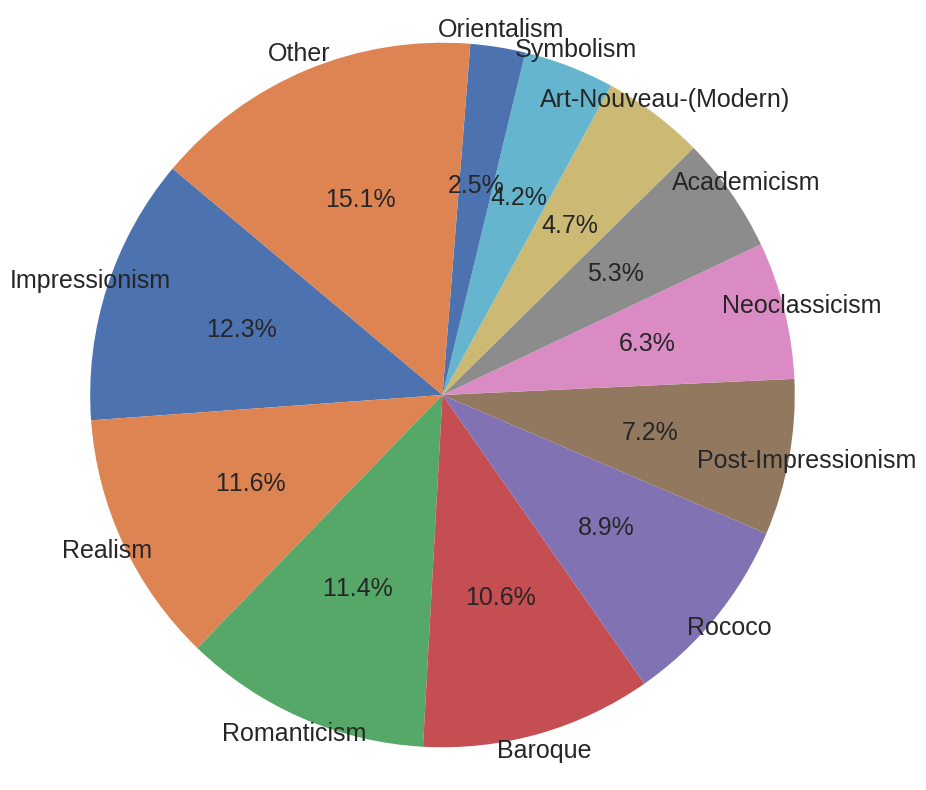

In [103]:
plot_pie_chart(wiki_filtered, 'Style', 0.02, "WikiArt")

In [104]:
def preview_images(rows, name='', link_processor=lambda x: x):
  '''
    Expects a 'Link' and a 'Year' column. The link should go directly to the image.
    The link_processor will be applied to the URL columns before fetching
    Name is a string for the title of the plot
  '''
  # print(rows)
  n_rows = 1
  n_cols = len(rows)
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
  axes = axes.flatten()
  size = 128

  for (i, row), ax in zip(rows.iterrows(), axes):
      # print(row)
      # print(f"Title: {row['Artwork']} | Artist: {row['Artist']}")
      try:
          url = link_processor(row['URL'])
          response = requests.get(url)
          img = Image.open(BytesIO(response.content))
          h, w = img.size
          long_dim = max(h, w)
          ratio = long_dim // size
          # print(h, w, ratio)
          img_resized = (h // ratio, w // ratio)
          img = img.resize(img_resized)
          ax.imshow(img)
          ax.axis('off')
          ax.set_title(f"Year: {row['Year']}")
      except Exception as e:
          print(f"Failed to load image from {link_processor(row['URL'])}: {e}")
          ax.text(0.5, 0.5, 'Error', ha='center', va='center')
          ax.axis('off')

  fig.savefig(f'{name} example images.png', dpi=300, bbox_inches='tight')

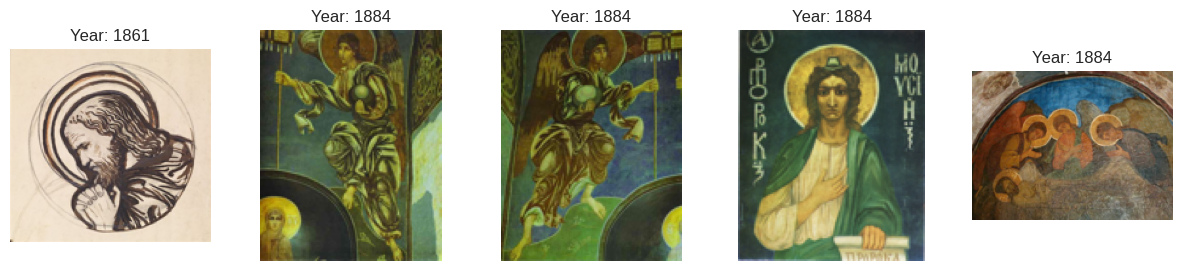

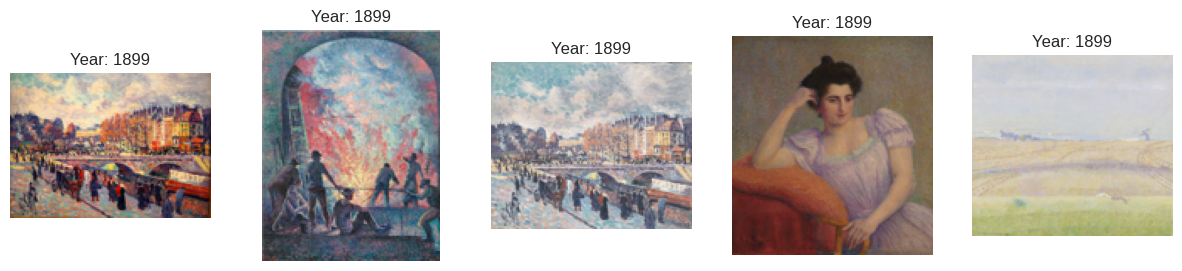

In [105]:
preview_images(wiki_filtered.head(5))
preview_images(wiki_filtered.tail(5))

In [106]:
def show_decades(df, title='Distribution of Western Paintings by Year (1600-1899)'):
  '''
    Plots the decades of paintings in the dataframe. Every row must have a value in the 'Year' column
  '''
  # Set the style for better visualization
  plt.style.use('seaborn-v0_8-whitegrid')
  sns.set_palette("deep")

  # Create the histogram
  plt.figure(figsize=(15, 8))

  # Create the histogram with custom bins (10-year intervals)
  bins = np.arange(1600, 1901, 10)  # From 1600 to 1900 in steps of 10
  plt.hist(df['Year'], bins=bins, alpha=0.75,
          color='darkblue', edgecolor='black')

  # Add a title and labels
  # plt.title(title, fontsize=16)
  plt.xlabel('Year', fontsize=18)
  plt.ylabel('Number of Paintings', fontsize=18)

  # Add a grid for better readability
  plt.grid(True, alpha=0.3)

  # Make x-axis labels more readable by rotating them and showing fewer labels
  plt.xticks(bins[::5], rotation=45, fontsize=14)  # Show every 5th bin label (50-year intervals)
  plt.yticks(fontsize=14)

  # Add context with text annotations
  avg_year = df['Year'].mean()
  median_year = df['Year'].median()
  plt.axvline(x=avg_year, color='red', linestyle='--', alpha=0.7,
              label=f'Mean Year: {avg_year:.1f}')
  plt.axvline(x=median_year, color='green', linestyle='--', alpha=0.7,
              label=f'Median Year: {median_year:.1f}')

  # Add a legend
  plt.legend()

  # Improve layout
  plt.tight_layout()
  plt.savefig(f'{title} all decades.png', dpi=300, bbox_inches='tight')
  plt.show()


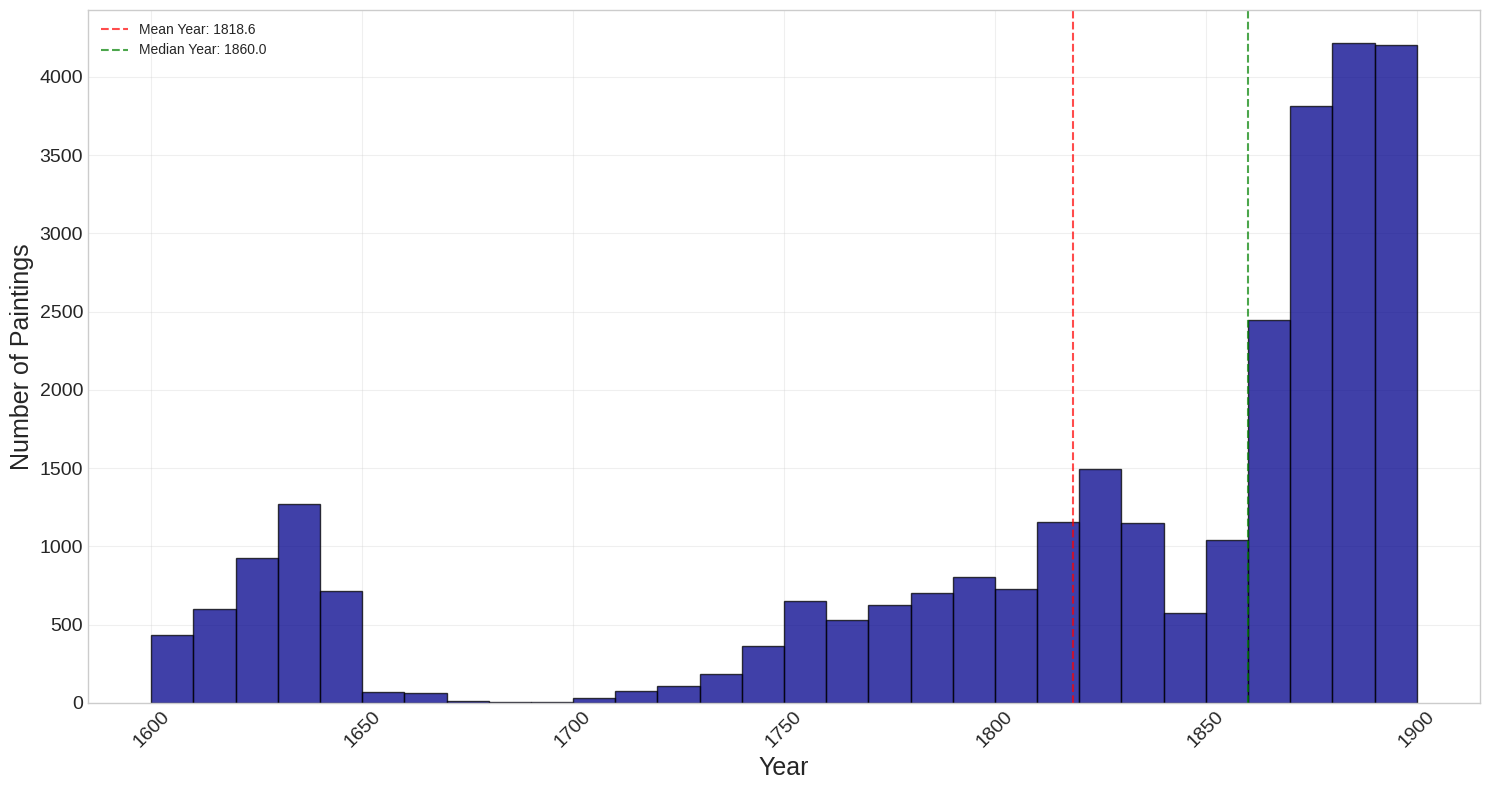

In [107]:
show_decades(wiki_filtered)

# [Web Gallery of Art](https://www.wga.hu/index.html) Dataset

- Downloaded txt catalog from [here](https://www.wga.hu/frames-e.html?/database/download/)
- ~10000 paintings with valid year range and from a Western 'School'

In [108]:
# Load the file into a DataFrame
wga = pd.read_csv('data/wga_catalog.txt', sep='\t', quotechar='"', encoding="ISO-8859-1", engine='python')

# Display the first few rows
wga.head()

,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,URL,FORM,TYPE,SCHOOL,TIMEFRAME
0,"AACHEN, Hans von","(b. 1552, Köln, d. 1615, Praha)",Venus and Adonis,1574-88,"Oil on canvas, 68 x 95 cm","Fogg Art Museum, Harvard University, Cambridge",https://www.wga.hu/html/a/aachen/adonis.html,painting,mythological,German,1601-1650
1,"AACHEN, Hans von","(b. 1552, Köln, d. 1615, Praha)",Allegory,1598,"Oil on copper, 56 x 47 cm","Alte Pinakothek, Munich",https://www.wga.hu/html/a/aachen/allegory.html,painting,mythological,German,1601-1650
2,"AACHEN, Hans von","(b. 1552, Köln, d. 1615, Praha)","Allegory of Peace, Art and Abundance",1602,"Oil on canvas, 197 x 142 cm","The Hermitage, St. Petersburg",https://www.wga.hu/html/a/aachen/allegorz.html,painting,mythological,German,1601-1650
3,"AACHEN, Hans von","(b. 1552, Köln, d. 1615, Praha)","Jupiter, Antiope and Cupid",1595-98,"Oil on copper, 31 x 21 cm","Kunsthistorisches Museum, Vienna",https://www.wga.hu/html/a/aachen/antiope.html,painting,mythological,German,1601-1650
4,"AACHEN, Hans von","(b. 1552, Köln, d. 1615, Praha)","Pallas Athena, Venus and Juno",1593,"Oil on canvas, 54 x 67 cm","Museum of Fine Arts, Boston",https://www.wga.hu/html/a/aachen/athena.html,painting,mythological,German,1601-1650


In [109]:
# Print all unique values in the SCHOOL column
unique_schools = wga['SCHOOL'].unique()
unique_schools

array(['German', 'Danish', 'Spanish', 'French', 'Italian', 'Dutch',
       'Scottish', 'Swedish', 'Flemish', 'Netherlandish', 'Swiss',
       'Russian', 'Greek', 'Other', 'American', 'English', 'Austrian',
       'Portuguese', 'Bohemian', 'Catalan', 'Hungarian', 'Irish',
       'Norwegian', 'Polish', 'Belgian', 'Finnish'], dtype=object)

In [110]:
# Step 1: Filter by 'French' school and 'painting' form
wga_filtered = wga[
    (wga['SCHOOL'] != 'Other') &
    (wga['FORM'] == 'painting')
].copy()

# Step 2: Create boolean mask for valid DATE
date_mask = []
for date in wga_filtered['DATE']:
    if pd.isna(date):
        date_mask.append(False)
    elif re.fullmatch(r'\d{4}', date):  # Single year
        year = int(date)
        date_mask.append(1600 <= year <= 1899)
    elif re.fullmatch(r'(\d{4})-(\d{4})', date):  # Year range
        start, end = map(int, date.split('-'))
        date_mask.append(1600 <= start <= 1899 and end <= 1899 and (end - start <= 10))
    elif re.fullmatch(r'c\.\s*\d{4}', date):  # Circa year
        year = int(re.search(r'\d{4}', date).group())
        date_mask.append(1600 <= year <= 1899)
    else:
        date_mask.append(False)

def get_start_date_wga(date):
    if re.fullmatch(r'\d{4}', date):  # Single year
        year = int(date)
        return year
    elif re.fullmatch(r'(\d{4})-(\d{4})', date):  # Year range
        start, end = map(int, date.split('-'))
        return start
    elif re.fullmatch(r'c\.\s*\d{4}', date):  # Circa year
        year = int(re.search(r'\d{4}', date).group())
        return year
    else:
        assert False, 'shouldn\'t have reached this branch in wga logic'

def get_end_date_wga(date):
    if re.fullmatch(r'\d{4}', date):  # Single year
        year = int(date)
        return year
    elif re.fullmatch(r'(\d{4})-(\d{4})', date):  # Year range
        start, end = map(int, date.split('-'))
        return end
    elif re.fullmatch(r'c\.\s*\d{4}', date):  # Circa year
        year = int(re.search(r'\d{4}', date).group())
        return year
    else:
        assert False, 'shouldn\'t have reached this branch in wga logic'

wga_filtered = wga_filtered[date_mask].copy()
wga_filtered['Start Date'] = wga_filtered['DATE'].apply(get_start_date_wga)
wga_filtered['End Date'] = wga_filtered['DATE'].apply(get_end_date_wga)

# Step 3: Create boolean mask for valid URL
url_mask = wga_filtered['URL'].str.match(r'^https?://[^\s<>"]+\.[^\s<>"]+$', na=False)

# Final filtered DataFrame
wga_filtered = wga_filtered[url_mask]

print(f"Original dataset had {len(wga)} rows.")
print(f"Filtered dataset has {len(wga_filtered)} rows.")
wga_filtered.head()

Original dataset had 52867 rows.
Filtered dataset has 10000 rows.


,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,URL,FORM,TYPE,SCHOOL,TIMEFRAME,Start Date,End Date
2,"AACHEN, Hans von","(b. 1552, Köln, d. 1615, Praha)","Allegory of Peace, Art and Abundance",1602,"Oil on canvas, 197 x 142 cm","The Hermitage, St. Petersburg",https://www.wga.hu/html/a/aachen/allegorz.html,painting,mythological,German,1601-1650,1602,1602
14,"AACHEN, Hans von","(b. 1552, Köln, d. 1615, Praha)",Anna of Tyrol,1604,"Oil on canvas, 58 x 48 cm","Kunsthistorisches Museum, Vienna",https://www.wga.hu/html/a/aachen/portrai3.html,painting,portrait,German,1601-1650,1604,1604
21,"AAGAARD, Carl Frederik","(b. 1833, Odense, d. 1895, København)",Deer beside a Lake,1888,"Oil on canvas, 53 x 82 cm",Private collection,https://www.wga.hu/html/a/aagaard/deerlake.html,painting,landscape,Danish,1851-1900,1888,1888
22,"AAGAARD, Carl Frederik","(b. 1833, Odense, d. 1895, København)",The Rose Garden,1877,"Oil on canvas, 98 x 80 cm",Private collection,https://www.wga.hu/html/a/aagaard/rosegard.html,painting,landscape,Danish,1851-1900,1877,1877
48,"ABBATI, Giuseppe","(b. 1836, Napoli, d. 1868, Firenze)",Landscape at Castiglioncello,1863,"Oil on panel, 10 x 30 cm","Galleria dell'Arte Moderna, Palazzo Pitti, Florence",https://www.wga.hu/html/a/abbati/abbati1.html,painting,landscape,Italian,1851-1900,1863,1863


Paintings count by century:
- 17th (1600-1700) Century: 4771 paintings
- 18th (1701-1800) Century: 2240 paintings
- 19th (1801-1899) Century: 2989 paintings


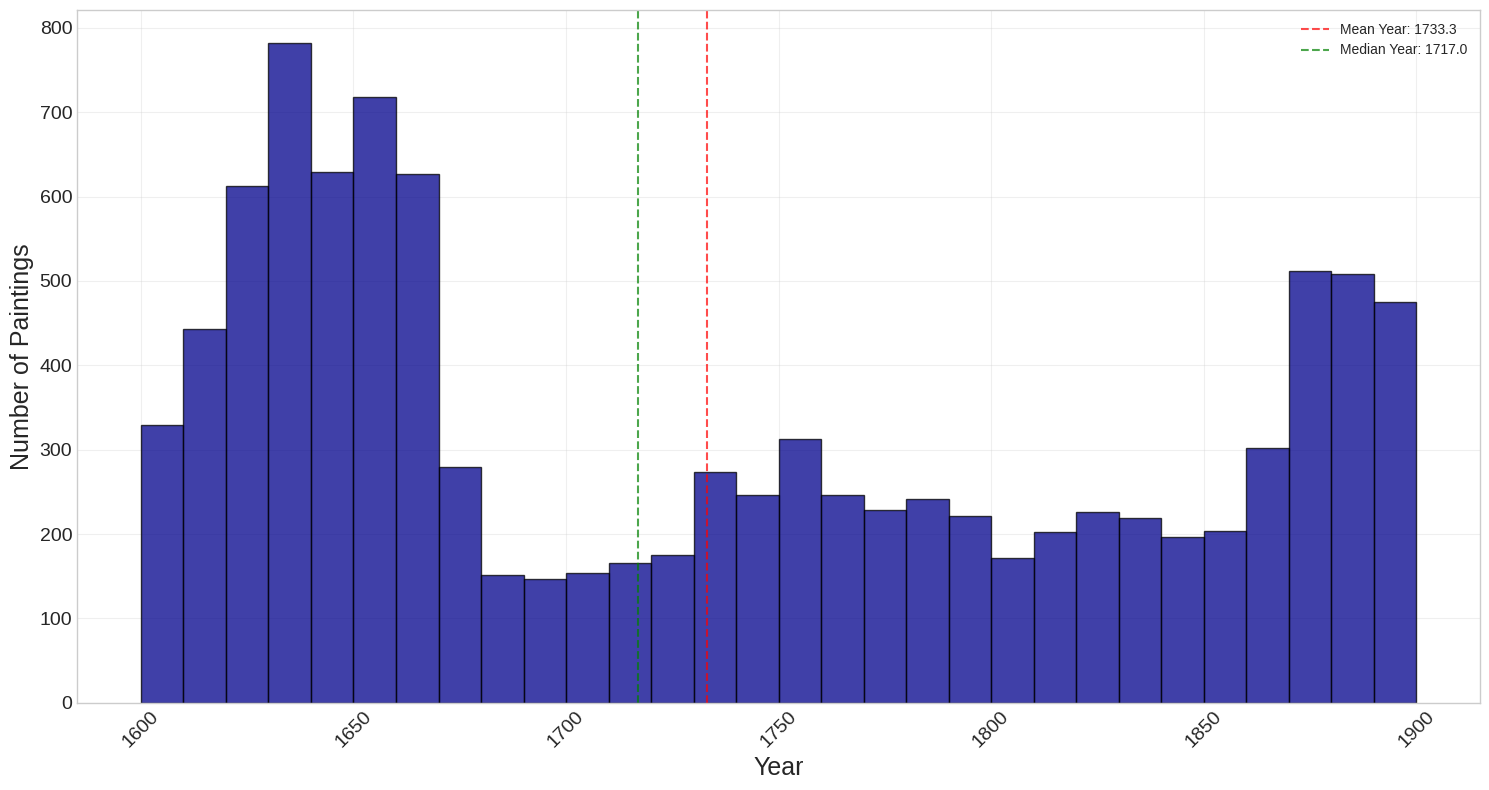

In [111]:
# Extract years from DATE column
def extract_year(date_str):
    if pd.isna(date_str):
        return None
    # For exact years (e.g., '1800')
    if re.fullmatch(r'\d{4}', date_str):
        return int(date_str)
    # For year ranges (e.g., '1800-1805')
    elif re.fullmatch(r'(\d{4})-(\d{4})', date_str):
        start, end = map(int, date_str.split('-'))
        return (start + end) // 2  # Use midpoint
    # For circa years (e.g., 'c. 1800')
    elif re.fullmatch(r'c\.\s*\d{4}', date_str):
        return int(re.search(r'\d{4}', date_str).group())
    return None

# Extract years and create new column
wga_filtered['Year'] = wga_filtered['DATE'].apply(extract_year)


# Count paintings per century
centuries = {
    '17th (1600-1700)': ((wga_filtered['Year'] >= 1600) &
                         (wga_filtered['Year'] <= 1700)).sum(),
    '18th (1701-1800)': ((wga_filtered['Year'] >= 1701) &
                         (wga_filtered['Year'] <= 1800)).sum(),
    '19th (1801-1899)': ((wga_filtered['Year'] >= 1801) &
                         (wga_filtered['Year'] <= 1899)).sum()
}

print("Paintings count by century:")
for century, count in centuries.items():
    print(f"- {century} Century: {count} paintings")

show_decades(wga_filtered)

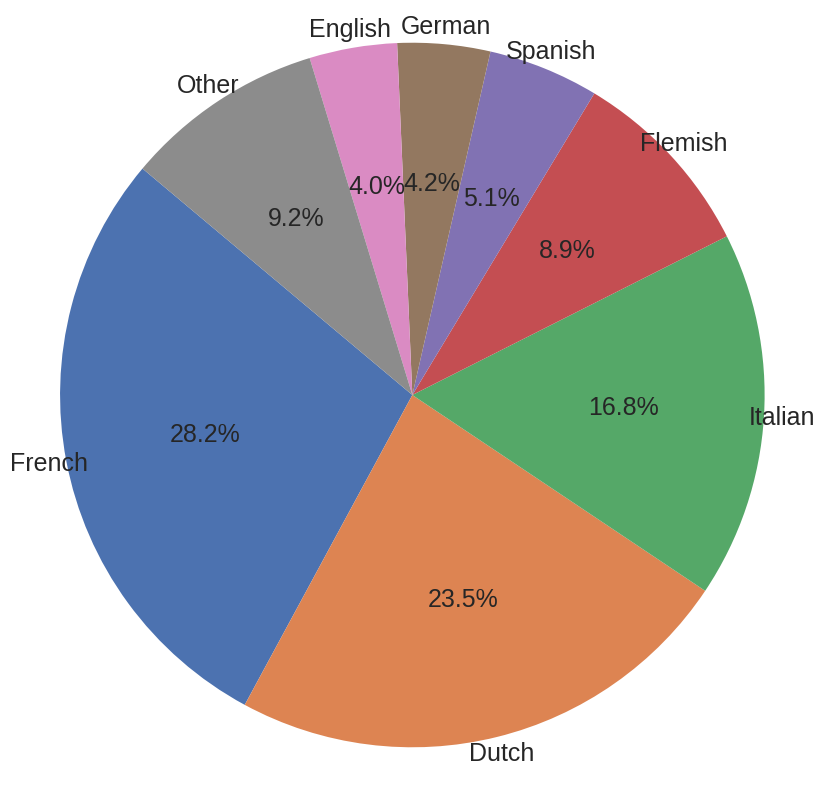

In [112]:
plot_pie_chart(wga_filtered, 'SCHOOL', 0.02, "WGA")

In [113]:
with open('data/wga.all', 'w') as file:
    file.write('\n'.join(wga_filtered['URL']))
print("URLs have been saved to 'wga.all'.")

URLs have been saved to 'wga.all'.


In [114]:
def convert_wga_html_url_to_jpg(url):
    """
    Convert a WGA artwork HTML page URL to its corresponding image URL.

    Example:
    https://www.wga.hu/html/a/aagaard/deerlake.html
    → https://www.wga.hu/art/a/aagaard/deerlake.jpg
    """
    try:
        if not url.startswith("https://www.wga.hu/html/") or not url.endswith(".html"):
            raise ValueError(f"URL {url}, does not match expected WGA format.")

        image_url = url.replace("/html/", "/art/").replace(".html", ".jpg")
        return image_url
    except Exception as e:
        print(f"Failed to convert URL: {url} — {e}")
        return None


wga_filtered['URL'] = wga_filtered['URL'].apply(convert_wga_html_url_to_jpg)

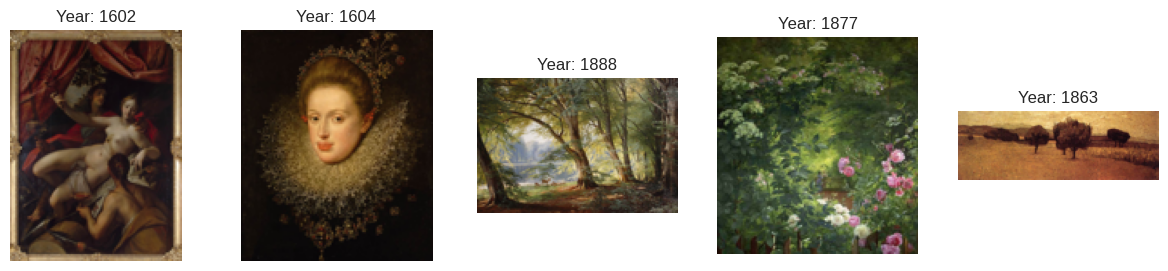

In [115]:
preview_images(wga_filtered.head())

In [116]:
years = wga_filtered['Year'].sort_values()

years.tail()

,Year
39593,1899
40486,1899
52742,1899
40899,1899
40900,1899


# [Joconde](https://www.data.gouv.fr/fr/) Dataset

- Direct download [link](https://data.culture.gouv.fr/api/explore/v2.1/catalog/datasets/base-joconde-extrait/exports/csv?lang=fr&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B)
- ~11954 paintings in date range. All paintings in this dataset are French.

In [117]:
joconde = pd.read_csv('data/base-joconde-extrait.csv', delimiter=';')
joconde.head()

<ipython-input-117-5f60d00ffe83>:1: DtypeWarning: Columns (1,26,30,34,35,36,38,42,47,49,52,53,54,55,57,66) have mixed types. Specify dtype option on import or set low_memory=False.
  joconde = pd.read_csv('data/base-joconde-extrait.csv', delimiter=';')


,Reference,Ancien_depot,Appellation,Ancienne_appartenance,Ancienne_attribution,Auteur,Bibliographie,Commentaires,Presence_image,Date_d_acquisition,Date_de_depot,Decouverte_collecte,Denomination,Lieu_de_depot,Description,Mesures,Date_de_mise_a_jour,Date_creation,Domaine,Region,Departement,Date_sujet_represente,Ecole_pays,Epoque,Exposition,Genese,Geographie_historique,Inscription,Numero_inventaire,Appellation_Musee_de_France,Lien_base_Arcade,Lieu_de_creation_utilisation,Localisation,Ville,Lien_Video,Manquant,Manquant commentaires,Millesime_de_creation,Millesime_d_utilisation,Code_Museofile,Nom_officiel_musee,Genre,Onomastique,Precisions_sur_l_auteur,Precisions_decouverte_collecte,Periode_de_l_original_copie,Periode_de_creation,Periode_d_utilisation,Precisions_inscriptions,Precisions_lieux_creations,Precisions_sujets_representes,Precisions_utilisation,References_Memoires,References_Merimee,Reference_MAJ,References_Palissy,Sujet_Represente,Lien_INHA,Source_de_la_representation,Statut_juridique,Materiaux_techniques,Titre,Utilisation,Lien_site_associe,coordonnees,Artiste_sous_droits,Date_entree_dans_le_domaine_public
0,08120043354,NaN,NaN,"Collection privée, Amis de Lafleur, 1974",NaN,anonyme,NaN,NaN,oui,1974,NaN,NaN,chapeau (élément d'ensemble);costume de marionnette,NaN,"Costume de marionnette constituant un chapeau à larges bords, réalisé à partir d'un matériau de récupération (feutre de laine)",Hauteur en cm 4.5 ; Longueur en cm 12 ; Largeur en cm 11,2021-07-22,2012-10-23,"spectacle - fête,ethnologie",Hauts-de-France,Somme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M.P.2012.0.1.189,Musée de France#au sens de la loi n°2002-5 du 4 janvier 2002,NaN,"France,Hauts-de-France,Somme,Amiens (lieu de création, lieu d'utilisation)",Amiens ; musée de Picardie,Amiens,NaN,NaN,NaN,NaN,NaN,M0812,musée de Picardie,NaN,NaN,NaN,NaN,NaN,2e quart 20e siècle;3e quart 20e siècle,2e quart 20e siècle;3e quart 20e siècle,NaN,NaN,NaN,"THEATRE DES AMIS DE LAFLEUR (utilisateur) ; Ce costume fit partie du jeu de marionnettes du théâtre des Amis de Lafleur, société de spectacle active à Amiens de 1930 à 1964",NaN,NaN,NaN,NaN,NaN,NaN,NaN,propriété de la commune;don manuel;Amiens;musée de Picardie,"laine, feutre",NaN,vêtement;spectacle,NaN,"49.890413, 2.295968",NaN,NaN
1,08120042847,NaN,NaN,"Collection privée, Amis de Lafleur, 1974",NaN,anonyme,NaN,NaN,oui,1974,NaN,NaN,livrée (élément d'ensemble);costume de marionnette,NaN,"Costume de marionnette constituant une livrée XVIIIe, réalisé à partir de différents matériaux de récupération (coton gratté ; galon argent ; satinette)",Hauteur en cm 34 ; Largeur en cm 27,2021-07-22,2012-10-23,"spectacle - fête,ethnologie",Hauts-de-France,Somme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M.P.2012.0.1.24,Musée de France#au sens de la loi n°2002-5 du 4 janvier 2002,NaN,"France,Hauts-de-France,Somme,Amiens (lieu de création, lieu d'utilisation)",Amiens ; musée de Picardie,Amiens,NaN,NaN,NaN,NaN,NaN,M0812,musée de Picardie,NaN,NaN,NaN,NaN,NaN,2e quart 20e siècle;3e quart 20e siècle,2e quart 20e siècle;3e quart 20e siècle,NaN,NaN,NaN,"THEATRE DES AMIS DE LAFLEUR (utilisateur) ; Ce costume fit partie du jeu de marionnettes du théâtre des Amis de Lafleur, société de spectacle active à Amiens de 1930 à 1964",NaN,NaN,NaN,NaN,NaN,NaN,NaN,propriété de la commune;don manuel;Amiens;musée de Picardie,"coton, gratté,fil de métal, galon,satinette",NaN,vêtement;spectacle,NaN,"49.890413, 2.295968",NaN,NaN
2,08120043318,NaN,NaN,"Collection privée, Amis de Lafleur, 1974",NaN,anonyme,NaN,NaN,oui,1974,NaN,NaN,casquette (élément d'ensemble);costume de marionnette,NaN,"Costume de marionnette constituant une casquette d'ouvrier, réalisé à partir de différents matériaux de récupération (satin lustré ; toile tailleur ; carton)",Hauteur en cm 7 ; Longueur en cm 12 ; Largeur en cm 9,2021-07-22,2012-10-23,"spectacle - fête,ethnologie",Hauts-de-France,Somme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M.P.2012.0.1.177,Musée de France#au sens de la loi n°2002-5 du 4 janvier 2002,NaN,"France,Hauts-de-F

In [118]:
# joconde.columns
for a in joconde['Ecole_pays'].unique():
  # print(a)
  pass

In [119]:
# Create a copy of the original dataframe
art_filtered = joconde.copy()

# Convert Millesime_de_creation to numeric, coercing errors to NaN
art_filtered['Millesime_de_creation'] = pd.to_numeric(art_filtered['Millesime_de_creation'], errors='coerce')

# Filter for years between 1600 and 1899
year_mask = (art_filtered['Millesime_de_creation'] >= 1600) & (art_filtered['Millesime_de_creation'] <= 1899)

# Filter for artwork with available images
art_filtered['has_image'] = art_filtered['Presence_image'].astype(str).str.lower()
image_mask = art_filtered['has_image'].isin(['1', 'true', 'yes', 'oui', 't', 'y', 'o'])

# Filter for paintings - check both Denomination and Genre columns
painting_terms = ['peinture', 'tableau', 'huile sur toile', 'painting', 'oil on canvas']
denomination_mask = art_filtered['Denomination'].str.lower().str.contains('|'.join(painting_terms), na=False)
genre_mask = art_filtered['Genre'].str.lower().str.contains('|'.join(painting_terms), na=False)

# Combine all masks
final_mask = year_mask & image_mask & (denomination_mask | genre_mask)

# Apply the filters
joconde_filtered = art_filtered[final_mask].copy()

# Print statistics
print(f"Original dataset had {len(joconde_filtered)} artworks")
print(f"After filtering for years 1600-1899: {year_mask.sum()} artworks")
print(f"After filtering for available images: {(year_mask & image_mask).sum()} artworks")
print(f"Final dataset has {len(joconde_filtered)} paintings from 1600-1899 with images")

# Display first few rows of the filtered dataset with relevant columns
columns_to_show = ['Millesime_de_creation', 'Periode_de_creation', 'Denomination',
                   'Genre', 'Auteur', 'Titre', 'Presence_image']

joconde_filtered[columns_to_show].head()

Original dataset had 11954 artworks
After filtering for years 1600-1899: 85590 artworks
After filtering for available images: 70662 artworks
Final dataset has 11954 paintings from 1600-1899 with images


,Millesime_de_creation,Periode_de_creation,Denomination,Genre,Auteur,Titre,Presence_image
291,1899.0,4e quart 19e siècle,tableau,NaN,PIOLAT J,Le Nohain,oui
294,1886.0,4e quart 19e siècle,tableau,NaN,RIGNOT-DUBAUX Marie-Madeleine,Portrait d'Auguste Dalligny,oui
532,1788.0,4e quart 18e siècle,tableau,masculin,Lenoir Simon-Bernard (1729-1791),Académie d'homme,oui
986,1665.0,3e quart 17e siècle,tableau,NaN,AELST Willem van (peintre),Bouquet de fleurs,oui
1023,1824.0,1er quart 19e siècle,tableau,NaN,RIOULT Louis Edouard (peintre),L'atelier du peintre,oui


In [120]:
# joconde_filtered['Millesime_de_creation'].unique()
# print(joconde_filtered.columns)
# joconde_filtered.rename(columns={})
# print(joconde_filtered[['Lien_site_associe', 'Lien_base_Arcade', 'Lien_INHA']].head(10))

In [121]:
# Create SSL context for insecure HTTP requests (must do because my computer
# doesn't recognize the French government's DNS).

ssl_context = ssl.create_default_context()
ssl_context.check_hostname = False
ssl_context.verify_mode = ssl.CERT_NONE

In [122]:
# Scrape and save the image urls for paintings using get_urls().
# - d_df: the df to get paintings from.
# - name: the name of the file to save urls to.

# to fix timeouts, adjust if needed

async def fetch(session, url):
    async with session.get(url, ssl=ssl_context) as response:
        return await response.read()

async def get_images(session, url):
    try:
        html = await fetch(session, url)
        soup = BeautifulSoup(html, 'html.parser')
        first_img_tag = soup.select_one(".fieldImages img, .swiper-slide img")
        first_image_url = first_img_tag["src"] if first_img_tag else None
        return first_image_url
    except Exception as e:
        raise e

async def get(urls):
    async with aiohttp.ClientSession() as session:
        tasks = [get_images(session, url) for url in urls]
        results = await asyncio.gather(*tasks)
        return results

def download(results, name):
    with open(f'{name}.log', 'w') as file:
        for s in results:
          if s:
            file.write(s + '\n')

async def get_urls(d_df, name):
    base_url = "https://www.pop.culture.gouv.fr/notice/joconde/{number}"
    urls = [base_url.format(number=i) for i in d_df['Reference']]
    results = await get(urls)
    download(results, name)
    return results

In [123]:
# !wget https://www.pop.culture.gouv.fr/notice/joconde/M0277000466

In [124]:
# Generate list of image urls for all French paintings.

# to download for the first time
# urls = await get_urls(joconde_filtered, 'all_joconde')

# read in afterwards
# urls = set()
# with open('all_joconde.log') as log:
#   lines = log.read().split()
#   for line in lines:
#     urls.add(line)

# or even this
joconde_filtered = pd.read_csv('Joconde filtered may 23.csv')

<ipython-input-124-6932d10a8dd8>:14: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  joconde_filtered = pd.read_csv('Joconde filtered may 23.csv')


In [125]:
# joconde_filtered['URL'] = urls
columns_to_show.append('URL')
joconde_filtered.to_csv('Joconde filtered may 23.csv')
print(len(joconde_filtered))
joconde_filtered[columns_to_show].head()

11954


,Millesime_de_creation,Periode_de_creation,Denomination,Genre,Auteur,Titre,Presence_image,URL
0,1899.0,4e quart 19e siècle,tableau,NaN,PIOLAT J,Le Nohain,oui,https://pop-perf-assets.s3.gra.io.cloud.ovh.net/joconde/01510001491/0000180.jpg
1,1886.0,4e quart 19e siècle,tableau,NaN,RIGNOT-DUBAUX Marie-Madeleine,Portrait d'Auguste Dalligny,oui,https://pop-perf-assets.s3.gra.io.cloud.ovh.net/joconde/01510001643/0000416.jpg
2,1788.0,4e quart 18e siècle,tableau,masculin,Lenoir Simon-Bernard (1729-1791),Académie d'homme,oui,https://pop-perf-assets.s3.gra.io.cloud.ovh.net/joconde/M0332006938/028731.jpg
3,1665.0,3e quart 17e siècle,tableau,NaN,AELST Willem van (peintre),Bouquet de fleurs,oui,https://pop-perf-assets.s3.gra.io.cloud.ovh.net/joconde/06770000013/0000745.jpg
4,1824.0,1er quart 19e siècle,tableau,NaN,RIOULT Louis Edouard (peintre),L'atelier du peintre,oui,https://pop-perf-assets.s3.gra.io.cloud.ovh.net/joconde/06770000430/0001211.jpg


Paintings count by century:
- 17th (1600-1700) Century: 1188 paintings
- 18th (1701-1800) Century: 1795 paintings
- 19th (1801-1899) Century: 8971 paintings


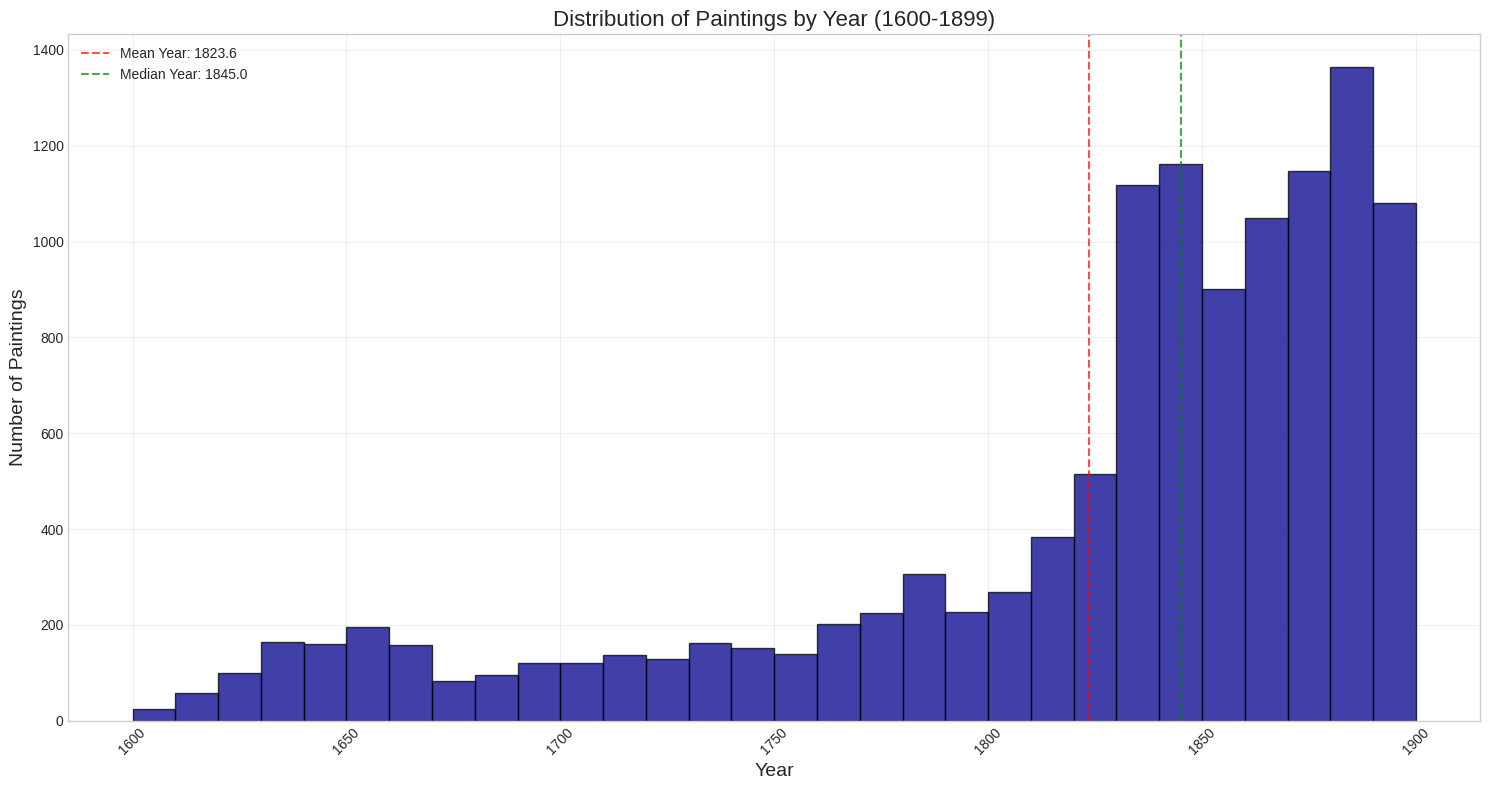

In [126]:
# Set the style for better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Ensure we're working with the filtered dataset
# Filter for only 1600-1899 range and remove any NaN values
paintings_1600_1899 = joconde_filtered[
    (joconde_filtered['Millesime_de_creation'] >= 1600) &
    (joconde_filtered['Millesime_de_creation'] <= 1899)
].dropna(subset=['Millesime_de_creation'])

# Create the histogram
plt.figure(figsize=(15, 8))

# Create the histogram with custom bins (10-year intervals)
bins = np.arange(1600, 1901, 10)  # From 1600 to 1900 in steps of 10
plt.hist(paintings_1600_1899['Millesime_de_creation'], bins=bins, alpha=0.75,
         color='darkblue', edgecolor='black')

# Add a title and labels
plt.title('Distribution of Paintings by Year (1600-1899)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Paintings', fontsize=14)

# Add a grid for better readability
plt.grid(True, alpha=0.3)

# Make x-axis labels more readable by rotating them and showing fewer labels
plt.xticks(bins[::5], rotation=45)  # Show every 5th bin label (50-year intervals)

# Add context with text annotations
avg_year = paintings_1600_1899['Millesime_de_creation'].mean()
median_year = paintings_1600_1899['Millesime_de_creation'].median()
plt.axvline(x=avg_year, color='red', linestyle='--', alpha=0.7,
            label=f'Mean Year: {avg_year:.1f}')
plt.axvline(x=median_year, color='green', linestyle='--', alpha=0.7,
            label=f'Median Year: {median_year:.1f}')

# Add a legend
plt.legend()

# Improve layout
plt.tight_layout()

# Count paintings per century for additional context
centuries = {
    '17th (1600-1700)': ((paintings_1600_1899['Millesime_de_creation'] >= 1600) &
                          (paintings_1600_1899['Millesime_de_creation'] <= 1700)).sum(),
    '18th (1701-1800)': ((paintings_1600_1899['Millesime_de_creation'] >= 1701) &
                          (paintings_1600_1899['Millesime_de_creation'] <= 1800)).sum(),
    '19th (1801-1899)': ((paintings_1600_1899['Millesime_de_creation'] >= 1801) &
                          (paintings_1600_1899['Millesime_de_creation'] <= 1899)).sum()
}

print("Paintings count by century:")
for century, count in centuries.items():
    print(f"- {century} Century: {count} paintings")

# Show the plot
plt.show()

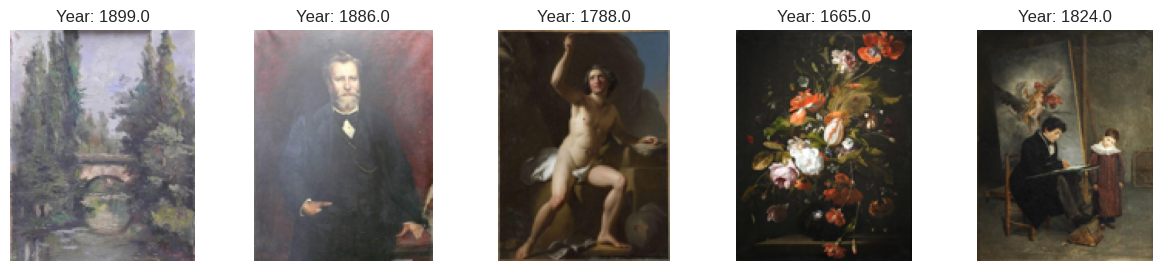

In [127]:
joconde_filtered['Year'] = joconde_filtered['Millesime_de_creation']
# joconde doesn't seem to do date ranges in their metadata
joconde_filtered['Start Date'] = joconde_filtered['Millesime_de_creation']
joconde_filtered['End Date'] = joconde_filtered['Millesime_de_creation']
preview_images(joconde_filtered.head())

478


<ipython-input-128-b205585ee7a8>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Netherlands' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  renamed[nethermask] = 'Netherlands'
<ipython-input-128-b205585ee7a8>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Netherlands' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  renamed[nethermask] = 'Netherlands'
<ipython-input-128-b205585ee7a8>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Netherlands' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  renamed[nethermask] = 'Netherlands'
<ipython-input-128-b205585ee7a8>:4: FutureWarning: Setting an item of incompatible dtype is

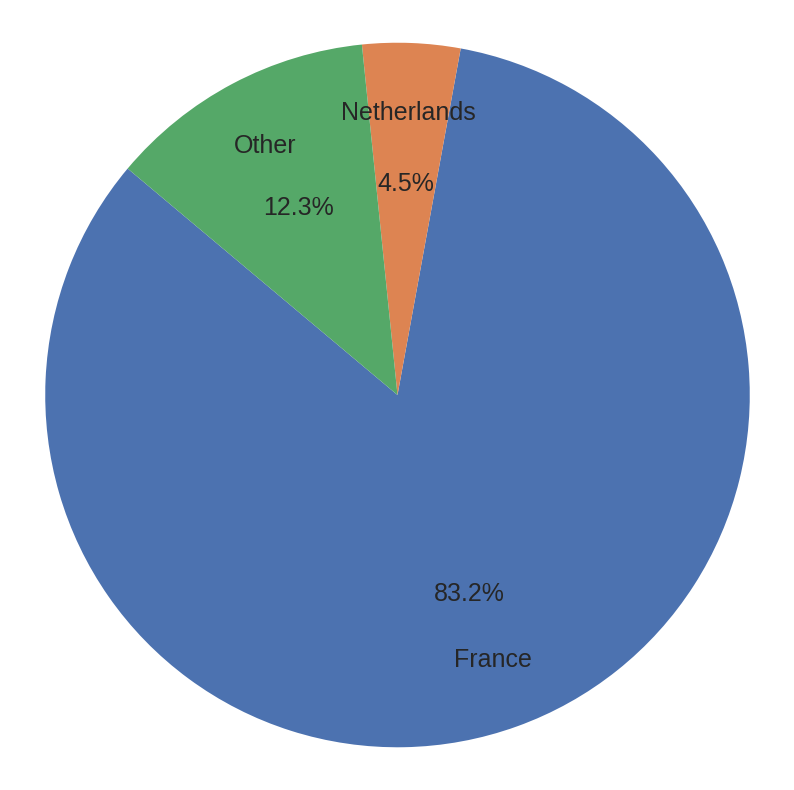

In [128]:
nethermask = joconde_filtered['Ecole_pays'] == 'Pays-Bas'
renamed = joconde_filtered.copy()
print(len(renamed[nethermask]))
renamed[nethermask] = 'Netherlands'

plot_pie_chart(renamed, 'Ecole_pays', 0.03, "Joconde", 0.8)

# [Rijksmuseum](https://www.rijksmuseum.nl/en) Dataset

- Data dumps and Search API [link](https://data.rijksmuseum.nl/docs/search)
- ~1506 artworks within date range and of `type='painting'`

In [129]:
rijks_df = pd.read_csv('rijks all data actual paints only not async.csv')
rijks_df.dropna(subset='URL', inplace=True)
rijks_df.head()

,Unnamed: 0,URL,Start Date,End Date,Year,Place,rijksurl
1,1,https://iiif.micr.io/jMCNh/full/max/0/default.jpg,1688.0,1688.0,1688.0,NaN,https://id.rijksmuseum.nl/200695108
2,2,https://iiif.micr.io/cCvFm/full/max/0/default.jpg,1682.0,1682.0,1682.0,NaN,https://id.rijksmuseum.nl/20079263
3,3,https://iiif.micr.io/TDdUO/full/max/0/default.jpg,1676.0,1676.0,1676.0,NaN,https://id.rijksmuseum.nl/200586378
4,4,https://iiif.micr.io/dQNot/full/max/0/default.jpg,1613.0,1613.0,1613.0,NaN,https://id.rijksmuseum.nl/200765122
5,5,https://iiif.micr.io/Qvftx/full/max/0/default.jpg,1606.0,1606.0,1606.0,NaN,https://id.rijksmuseum.nl/200767282


1506


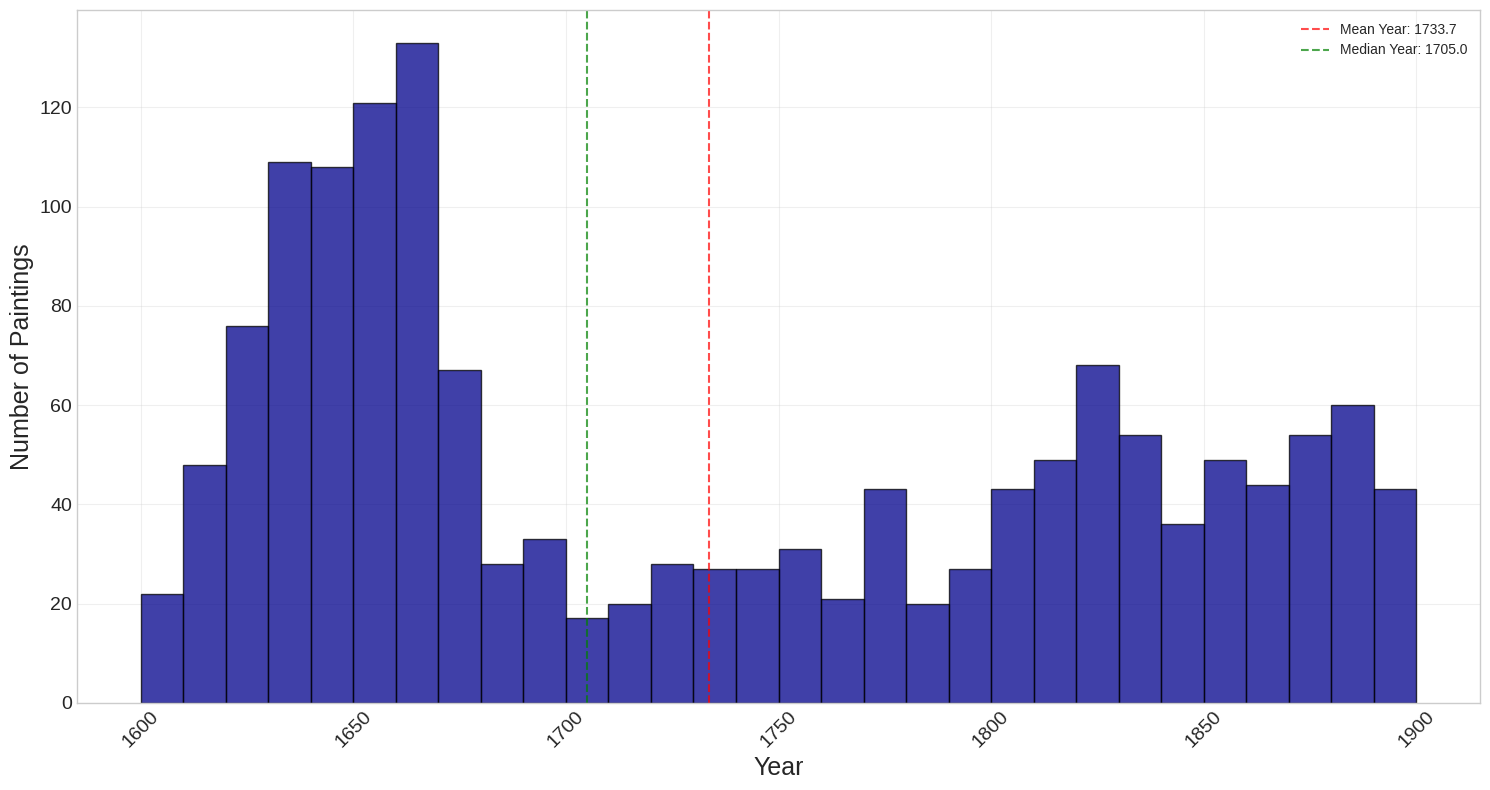

In [130]:
print(len(rijks_df))
show_decades(rijks_df)

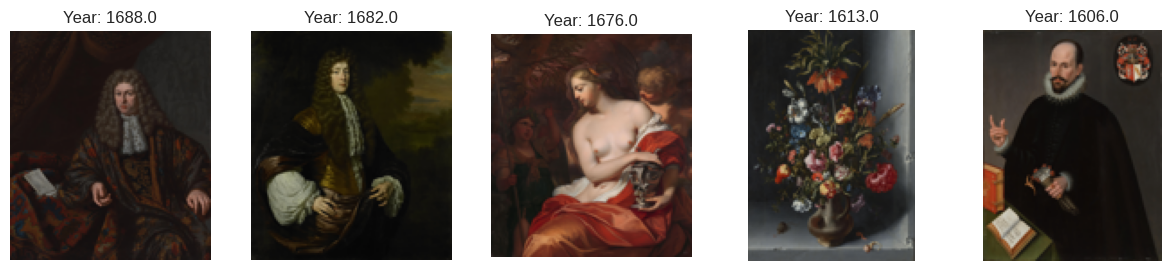

In [131]:
preview_images(rijks_df.head())

# All statistics

In [132]:
def print_dataset_stats(df_full, df_name, col_map={'URL': 'URL', 'Start Date': 'Start Date', 'End Date': 'End Date', 'Year': 'Year'}, batch=10):
  '''
    Will print out these statistics:
     - Total number of artworks (rows).
     - Earliest Year
     - Latest Year
     - Average year range per artwork (Start date - end date) / N
     - Graph showing the amount pieces per year window (start - end date) there are
     - Resolution average out of `batch` num of paintings

    Param:
      df - Must have a 'Year', 'Start Date', 'End Date', and 'URL' column
      df_name - string for the name of this dataset
      col_map - mapping of column names to URL, Start Date, End Date, and Year from the original df
      batch - num of paintings to get average resolution from.
  '''
  df = df_full[list(col_map.keys())].rename(columns=col_map)
  print(f'=============== Stats for {df_name} ===============')
  print(f' -> Total number of artworks: {len(df)}')
  print(f' -> Total artworks with a valid URL: {len(df["URL"].dropna())}')

  # earliest and latest year
  year_sort = df['Year'].sort_values()
  print(f' -> Earlist Year: {year_sort.iloc[0]}')
  print(f' -> Latest Year: {year_sort.iloc[-1]}')

  # average year range
  dif = df['End Date'] - df['Start Date']
  for val in dif:
    assert val <= 10, f'{df_name} has a start - end date diff > 10!'
  avg = dif.mean()
  print(f' -> Average year range per artwork (Start - End) / N: {avg}')

  # graph window range of all years
  counts = dif.value_counts().sort_index()

  plt.figure(figsize=(8, 5))
  plt.bar(counts.index, counts.values)
  plt.xlabel('Start - End Year Difference')
  plt.ylabel('Counts')
  plt.title(f'Frequency of Each Year Window in {df_name}')
  plt.xticks(range(0, 11))  # Ensure ticks go from 0 to 10
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.show()

  print('\n\n')

# Merge the DataFrames

Will put them all into the `full_data` variable. With the columns:
- 'Year': The year the painting is created. Must be between 1600 and 1900. If the painting has a year range, the year will be the median value of the start/end dates
- 'Start Date': The start date of the painting. If the painting was made in one year this will be the same as end date
- 'End Date': The end date of the painting. Must be within 10 years after Start Date.
- 'URL': A link to the image that can be requested and obtained. The `preview_images` function will be able to visualize rows with this format.

=============== Stats for Wiki Art ===============
 -> Total number of artworks: 28997
 -> Total artworks with a valid URL: 28997
 -> Earlist Year: 1600
 -> Latest Year: 1899
 -> Average year range per artwork (Start - End) / N: 0.28609856192019867


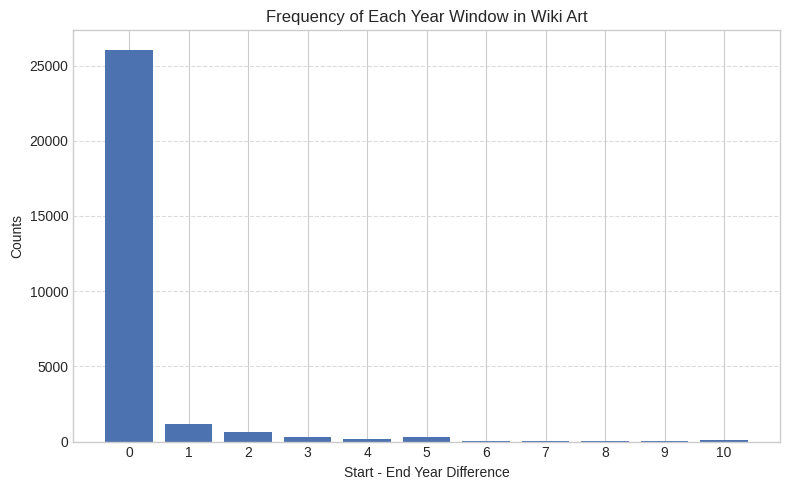




=============== Stats for WGA ===============
 -> Total number of artworks: 10000
 -> Total artworks with a valid URL: 10000
 -> Earlist Year: 1600
 -> Latest Year: 1899
 -> Average year range per artwork (Start - End) / N: 0.0096


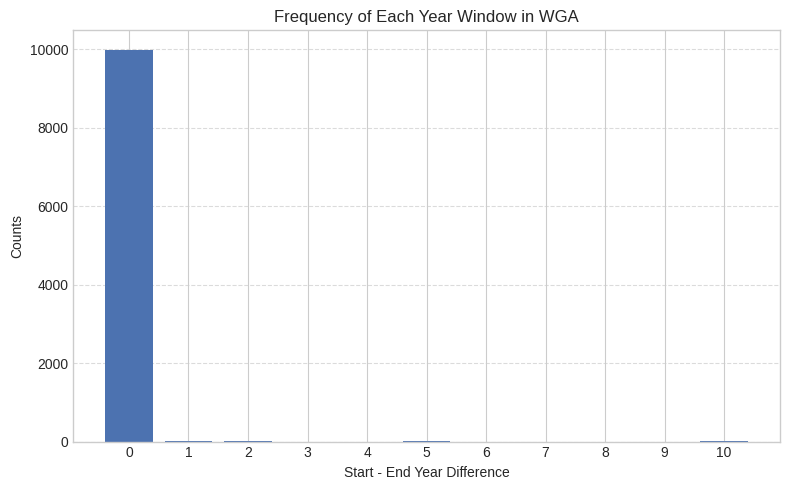




=============== Stats for Joconde ===============
 -> Total number of artworks: 11954
 -> Total artworks with a valid URL: 11849
 -> Earlist Year: 1600.0
 -> Latest Year: 1899.0
 -> Average year range per artwork (Start - End) / N: 0.0


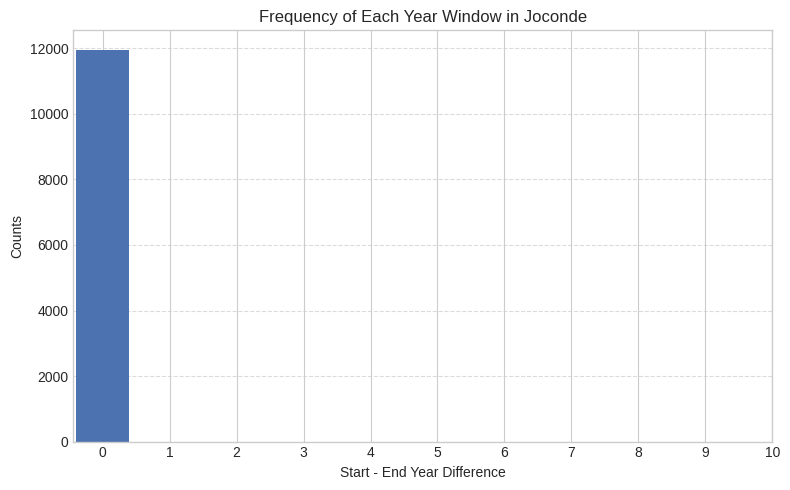




=============== Stats for Rijks ===============
 -> Total number of artworks: 1506
 -> Total artworks with a valid URL: 1506
 -> Earlist Year: 1600.0
 -> Latest Year: 1899.0
 -> Average year range per artwork (Start - End) / N: 0.0


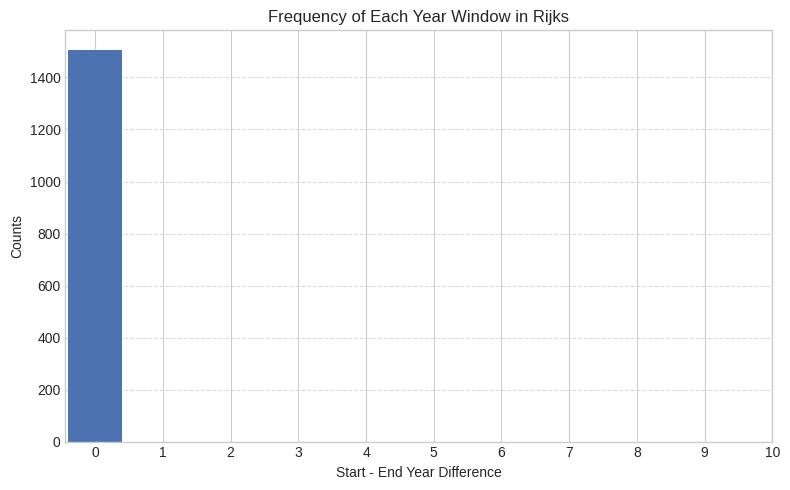

In [133]:
# all the dfs
all_dfs = [wiki_filtered, wga_filtered, joconde_filtered, rijks_df]

# names of the dfs, matches order of all_dfs
all_names = ['Wiki Art', 'WGA', 'Joconde', 'Rijks']

# The mapping for each original dataframe column name and the resulting one. Matches order of all_dfs
column_maps = [
    {'URL': 'URL', 'Start Date': 'Start Date', 'End Date': 'End Date', 'Year': 'Year'},
    {'URL': 'URL', 'Start Date': 'Start Date', 'End Date': 'End Date', 'Year': 'Year'},
    {'Millesime_de_creation': 'Year', 'Start Date': 'Start Date', 'End Date': 'End Date', 'URL': 'URL'},
    {'Year': 'Year', 'Start Date': 'Start Date', 'End Date': 'End Date', 'URL': 'URL'}
]

for one_df, name, col_map in zip(all_dfs, all_names, column_maps):
  print_dataset_stats(one_df, name, col_map=col_map)

## Table of per Dataset stats

\begin{table*}[ht]
\centering
\caption{Dataset comparison across relevant features for year prediction of artworks.}
\label{tab:dataset_comparison}
\begin{tabular}{lccccc}
\toprule
\textbf{Feature \ Dataset} & \textbf{Wiki Art} & \textbf{WGA} & \textbf{Joconde} & \textbf{Rijks} & \textbf{\underline{All Datasets}}\\
\midrule
Number of Artworks           &       28997        &         10000      &       11954        &    1506     & 52457      \\
Publicly Available           &     \checkmark          &          \checkmark     &        \checkmark       &      \checkmark  & \checkmark       \\
Year Label Granularity \footnote{Average year 'window' range}       &       0.2861        &       0.0096        &     0.0          &       0.0    & 0.1600    \\
Earliest Year                &        1600       &      1600         &      1600         &      1600      &  1600  \\
Latest Year                  &     1899          &        1899       &      1899         &       1899  & 1899      \\
Geographic Scope             &      \makecell{Western \\ Europe/America}         &       \makecell{Western \\ Europe/America}        &     \makecell{Predominantly \\ France}          &        Western Europe    & \makecell{Western \\ Europe/America} \\
\bottomrule
\end{tabular}
\end{table*}

In [134]:
# Standardize and collect the relevant columns
standardized = []
for df, col_map in zip(all_dfs, column_maps):
    subset = df[list(col_map.keys())].rename(columns=col_map)
    standardized.append(subset)

# Merge all into one
full_data = pd.concat(standardized, ignore_index=True)
for col in ['Year', 'Start Date', 'End Date']:
    full_data[col] = pd.to_numeric(full_data[col], errors='coerce').astype('Int64')
print(f'Compiled {len(full_data)} rows from all {len(all_dfs)} datasets')
full_data.head()

Compiled 52457 rows from all 4 datasets


,URL,Start Date,End Date,Year
0,https://uploads7.wikiart.org/00158/images/edward-burne-jones/preview-1904-p540.jpg,1861,1862,1861
1,https://uploads7.wikiart.org/images/mikhail-vrubel/angel-with-labara-1884.jpg,1884,1884,1884
2,https://uploads0.wikiart.org/images/mikhail-vrubel/angel-with-labara-1884-1.jpg,1884,1884,1884
3,https://uploads4.wikiart.org/images/mikhail-vrubel/moses-1884.jpg,1884,1884,1884
4,https://uploads4.wikiart.org/images/mikhail-vrubel/pieta-1884.jpg,1884,1884,1884


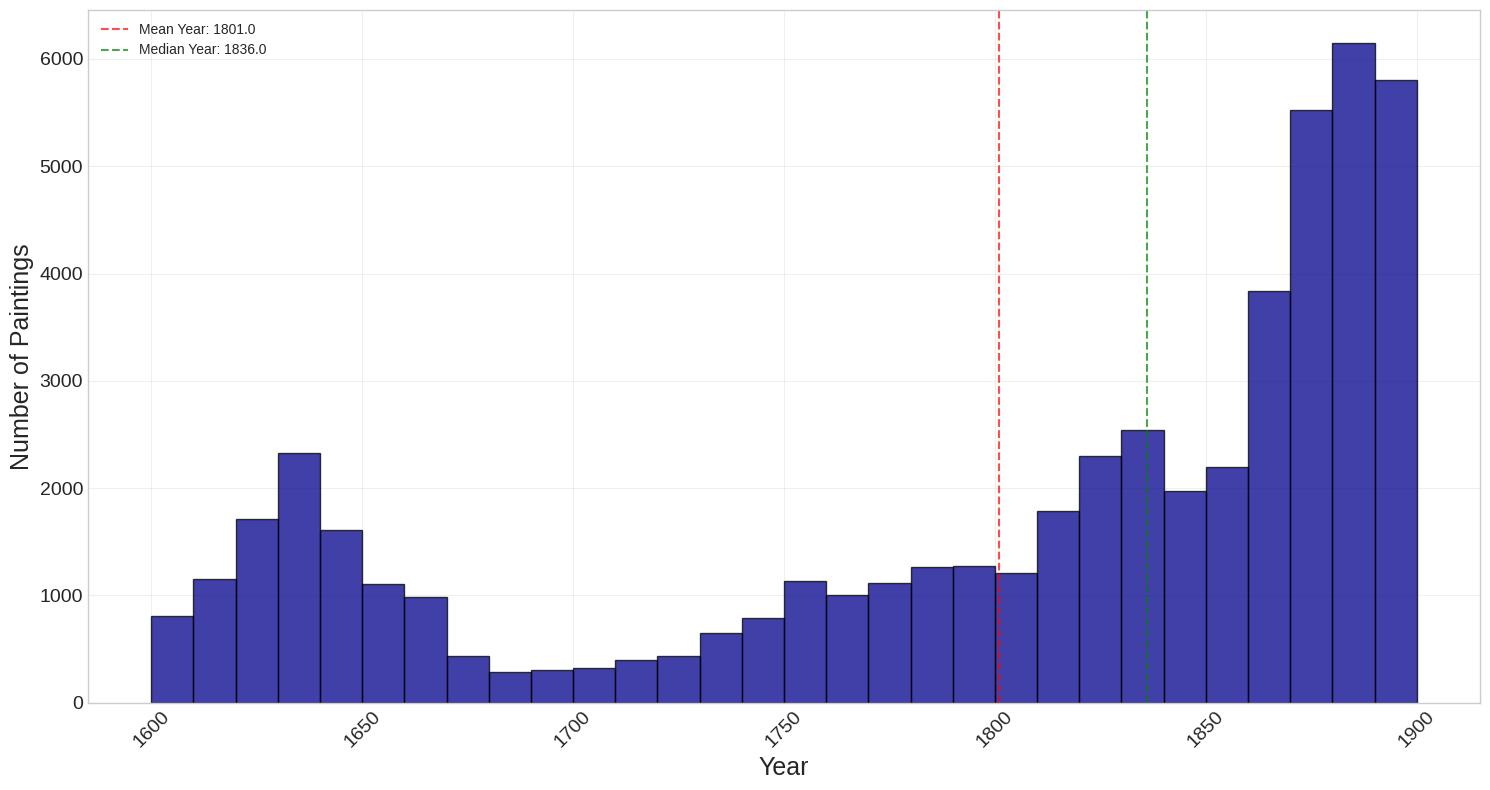

In [135]:
show_decades(full_data, 'Distribution of Western Paintings in all Datasets by Year (1600-1899)')

In [136]:
# r = np.random.randint(0, len(full_data)-1, size=10)
sort = full_data.sort_values('Year')

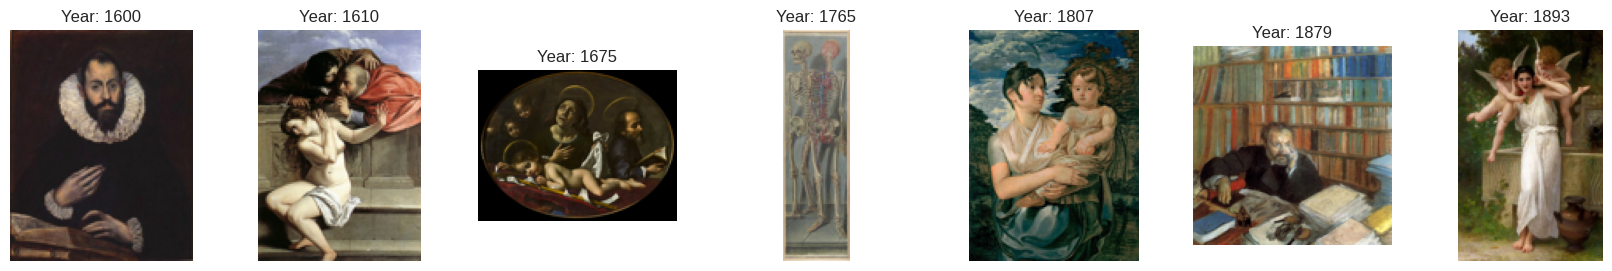

In [137]:
preview_images(sort.iloc[[10, 1000, 10000, 15000, 20000, 40100, 49001]])

=============== Stats for All Datasets ===============
 -> Total number of artworks: 52457
 -> Total artworks with a valid URL: 52352
 -> Earlist Year: 1600
 -> Latest Year: 1899
 -> Average year range per artwork (Start - End) / N: 0.15997864917932783


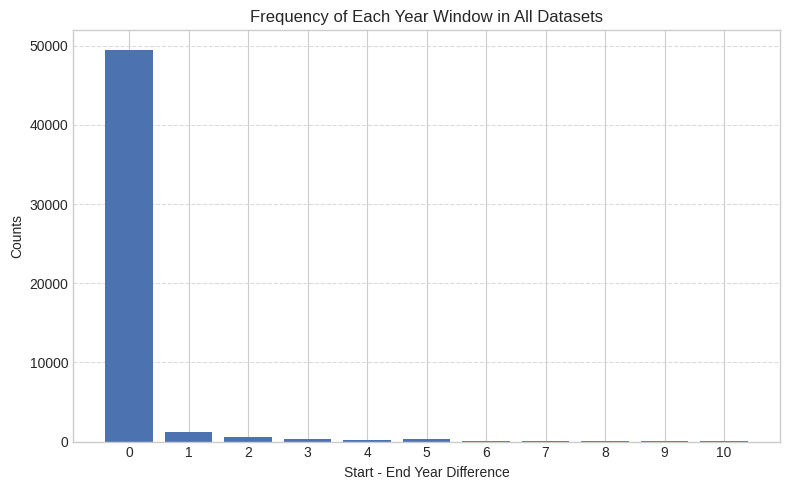

In [138]:
print_dataset_stats(full_data, 'All Datasets')

In [139]:
full_data.to_csv('full painting data.csv')